In [98]:
import pandas as pd
import re
import pgeocode
import math
import pygad
import numpy as np
from itertools import combinations
from geopy import distance

In [204]:
postcodes = pd.read_csv("institute_postcodes.csv")
glickos = pd.read_csv("team_ratings.csv")
results = pd.read_csv("bucs_results.csv")

results = results.drop(columns=['No Score Type', 'Walkover Reason','Knockout Fixtures', 'Number of Walkovers', 'Voids', 'Blowout Game(s)', 'Zero Score?', 'Blowout to Zero', 'Team Conceding Walkover', 'Fixtures',
       'League Fixtures', 'Time','Date' ])

results = results[['Home', 'Team Type']]


# Function to remove numbers and certain words from a string
def clean_team_name(s):
    # Remove all numbers from string
    s = re.sub(r'\d+', '', s)
    # Remove "Women's" and "Men's" from string
    s = s.replace("Women's ", "").replace("Men's ", "")
    # Remove extra spaces
    s = " ".join(s.split())
    return s

def extract_integers(input_string):
    # Use a regular expression to match all integer values in the input string
    integer_matches = re.findall(r'\d+', input_string)

    # Convert the matched strings to integers and retur
    return integer_matches


latlong = pgeocode.Nominatim('GB')


def get_lat_long(postcode):
    if postcode == 'nan':
        return 0, 0
    else:
        query = latlong.query_postal_code(postcode)
        return query['latitude'], query['longitude']

postcodes

,Modified Home,Venue Postcode,Unnamed: 2
0,Plymouth,PL6 8BH,NaN
1,Heriot-Watt,EH16 5LL,NaN
2,Aberdeen,AB24 5RU,NaN
3,Edinburgh,EH16 5LL,NaN
4,Glasgow,G20 0SP,NaN
...,...,...,...
118,Brighton (Brighton),BN21 1EA,NaN
119,Chester,CH1 4AR,NaN
120,Sunderland,SR2 8PD,NaN
121,Anglia Ruskin,CB3 0EQ,NaN


In [205]:
get_lat_long("ox13 5gp")

(51.673544444444445, -1.3561166666666666)

In [206]:
results.columns

Index(['Home', 'Team Type'], dtype='object')

In [207]:
postcodes = postcodes.drop('Unnamed: 2', axis=1)
postcodes['Lat'] = postcodes.apply(lambda row: get_lat_long(row['Venue Postcode'])[0], axis=1)
postcodes['Lon'] = postcodes.apply(lambda row: get_lat_long(row['Venue Postcode'])[1], axis=1)

In [208]:
results['Home Institute'] = results.apply(lambda row: clean_team_name(row.Home), axis=1)
results['Home Team'] = results.apply(lambda row: extract_integers(row.Home)[0], axis=1)


In [209]:
glickos.sort_values('gs', ascending=False)

,names,gs,rd
11,Nottingham Women's 1,3075.127610,53.224048
474,Loughborough Men's 1,3050.598118,52.629578
31,Durham Women's 1,3050.573762,52.618688
218,Durham Men's 1,3044.673029,52.618989
71,Exeter Men's 1,3044.512084,52.628009
...,...,...,...
422,Kent Women's 4,566.862789,55.173929
41,Edinburgh Napier Women's 2,562.449322,53.262612
527,Stirling Women's 4,549.298991,52.654349
450,Leeds Women's 8,523.914325,55.809897


In [210]:
mdf = pd.merge(left=glickos, right=results, how='left', left_on='names', right_on='Home')
mdf = mdf.drop_duplicates()
mdf = pd.merge(left=mdf, right=postcodes, left_on='Home Institute', right_on='Modified Home' )

mens_df = mdf[mdf['Team Type'] == 'Men\'s'].sort_values('gs', ascending=False)

In [211]:
mdf

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
0,Cardiff Met Women's 2,2010.910113,49.940051,Cardiff Met Women's 2,Women's,Cardiff Met,2,Cardiff Met,CF5 2YB,51.471875,-3.275817
1,Cardiff Met Men's 2,1512.281593,50.426858,Cardiff Met Men's 2,Men's,Cardiff Met,2,Cardiff Met,CF5 2YB,51.471875,-3.275817
2,Cardiff Met Women's 1,2302.550227,53.223263,Cardiff Met Women's 1,Women's,Cardiff Met,1,Cardiff Met,CF5 2YB,51.471875,-3.275817
3,Cardiff Met Women's 3,1229.592049,49.930301,Cardiff Met Women's 3,Women's,Cardiff Met,3,Cardiff Met,CF5 2YB,51.471875,-3.275817
4,Cardiff Met Women's 4,919.110336,51.538756,Cardiff Met Women's 4,Women's,Cardiff Met,4,Cardiff Met,CF5 2YB,51.471875,-3.275817
...,...,...,...,...,...,...,...,...,...,...,...
591,Staffordshire Men's 1,1192.074964,55.830719,Staffordshire Men's 1,Men's,Staffordshire,1,Staffordshire,ST15 0BW,52.901923,-2.122292
592,Brighton Women's 1 (Eastbourne),1948.750834,62.372482,Brighton Women's 1 (Eastbourne),Women's,Brighton (Eastbourne),1,Brighton (Eastbourne),BN3 7BW,50.836725,-0.179625
593,Brighton Women's 3 (Eastbourne),708.546901,62.380943,Brighton Women's 3 (Eastbourne),Women's,Brighton (Eastbourne),3,Brighton (Eastbourne),BN3 7BW,50.836725,-0.179625
594,Anglia Ruskin Women's 1,900.027664,65.402777,Anglia Ruskin Women's 1,Women's,Anglia Ruskin,1,Anglia Ruskin,CB3 0EQ,52.211421,0.098317


In [212]:
allocated_ids = []

In [213]:
b_prem = mens_df[mens_df["Home Team"]=='1'][:10]
b_prem

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
35,Loughborough Men's 1,3050.598118,52.629578,Loughborough Men's 1,Men's,Loughborough,1,Loughborough,LE11 3TU,52.766700,-1.200000
188,Durham Men's 1,3044.673029,52.618989,Durham Men's 1,Men's,Durham,1,Durham,DH1 3SE,54.774820,-1.567140
283,Exeter Men's 1,3044.512084,52.628009,Exeter Men's 1,Men's,Exeter,1,Exeter,EX4 4QN,50.737760,-3.529700
51,Nottingham Men's 1,3039.448520,52.628932,Nottingham Men's 1,Men's,Nottingham,1,Nottingham,NG7 2PS,52.953600,-1.150500
110,Nottingham Trent Men's 1,3017.908731,53.234367,Nottingham Trent Men's 1,Men's,Nottingham Trent,1,Nottingham Trent,NG11 8NS,52.878620,-1.195240
195,Oxford Men's 1,3015.652333,52.628946,Oxford Men's 1,Men's,Oxford,1,Oxford,OX4 1SR,51.723725,-1.224375
77,Edinburgh Men's 1,3008.805624,52.631735,Edinburgh Men's 1,Men's,Edinburgh,1,Edinburgh,EH16 5LL,55.922500,-3.151133
204,Bath Men's 1,2974.587072,53.228721,Bath Men's 1,Men's,Bath,1,Bath,BA2 7AY,51.354739,-2.391057
95,Birmingham Men's 1,2969.867568,53.230028,Birmingham Men's 1,Men's,Birmingham,1,Birmingham,B15 2GR,52.462300,-1.921200
273,Manchester Men's 1,2337.188307,49.931336,Manchester Men's 1,Men's,Manchester,1,Manchester,M14 6HE,53.448200,-2.225700


In [214]:
b_ns_split = mens_df.drop(b_prem.index)[:20]
allocated_ids = allocated_ids + [x for x in b_prem.index]
b_ns_split

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
284,Exeter Men's 2,2352.947633,53.212962,Exeter Men's 2,Men's,Exeter,2,Exeter,EX4 4QN,50.737760,-3.529700
54,Nottingham Men's 2,2348.391439,53.220961,Nottingham Men's 2,Men's,Nottingham,2,Nottingham,NG7 2PS,52.953600,-1.150500
108,Nottingham Trent Men's 2,2341.194369,51.510596,Nottingham Trent Men's 2,Men's,Nottingham Trent,2,Nottingham Trent,NG11 8NS,52.878620,-1.195240
226,Reading Men's 1,2329.652272,50.973817,Reading Men's 1,Men's,Reading,1,Reading,RG6 6UR,51.439600,-0.929200
185,Durham Men's 2,2326.065543,52.619390,Durham Men's 2,Men's,Durham,2,Durham,DH1 3SE,54.774820,-1.567140
366,Cambridge Men's 1,2320.251638,53.216815,Cambridge Men's 1,Men's,Cambridge,1,Cambridge,CB3 0EQ,52.211421,0.098317
237,Bristol Men's 2,2314.065621,49.927489,Bristol Men's 2,Men's,Bristol,2,Bristol,BS9 2BJ,51.487400,-2.626600
6,Cardiff Met Men's 1,2312.630128,53.845534,Cardiff Met Men's 1,Men's,Cardiff Met,1,Cardiff Met,CF5 2YB,51.471875,-3.275817
10,Cardiff Men's 1,2308.345523,52.632661,Cardiff Men's 1,Men's,Cardiff,1,Cardiff,CF14 3AT,51.519900,-3.204000
100,Birmingham Men's 2,2307.569958,53.223878,Birmingham Men's 2,Men's,Birmingham,2,Birmingham,B15 2GR,52.462300,-1.921200


In [215]:
b_ns_split.loc[54]

names             Nottingham Men's 2
gs                       2348.391439
rd                         53.220961
Home              Nottingham Men's 2
Team Type                      Men's
Home Institute            Nottingham
Home Team                          2
Modified Home             Nottingham
Venue Postcode               NG7 2PS
Lat                          52.9536
Lon                          -1.1505
Name: 54, dtype: object

In [216]:
b_ns_split[:20].index

Int64Index([284,  54, 108, 226, 185, 366, 237,   6,  10, 100, 251, 235,  38,
            260, 310, 125, 178,  68, 221, 383],
           dtype='int64')

# its genetic algorithm time


In [217]:

def fitness_func_fact(d_tab=b_ns_split, n_teams_per_league=10, n_leagues=2):
    def fitness_func(solution, solution_idx):
        """
        solution will be a list of x IDs, divisible by n
        """
        leagues = np.array_split(solution, n_leagues)
        sum_dist = 0
        for l in leagues:
            lat_longs = []
            for id_ in l:
                id_ = int(id_)
                lat = d_tab.loc[id_].Lat
                lon = d_tab.loc[id_].Lon
                lat_longs.append((lat, lon))
            comb_lat_longs = combinations(lat_longs, 2)
            for comb in comb_lat_longs:
                sum_dist += distance.distance(comb[0], comb[1]).km
        return 1.0/sum_dist
    return fitness_func

function_inputs = [x for x in b_ns_split.index]
print(function_inputs)
num_generations = 200
num_parents_mating = 4

fitness_function = fitness_func_fact()

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in b_ns_split.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

[284, 54, 108, 226, 185, 366, 237, 6, 10, 100, 251, 235, 38, 260, 310, 125, 178, 68, 221, 383]


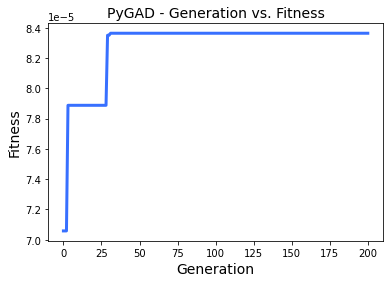

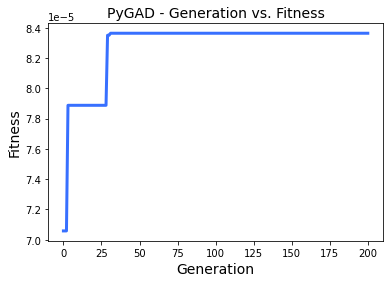

In [218]:
ga_instance.plot_fitness()

In [219]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Parameters of the best solution : [185  54  38 366 108 125 100 310 251 260 383  10 237 235   6 226  68 221
 178 284]
Fitness value of the best solution = 597.7606813370783
Index of the best solution : 0


In [220]:
allocated_ids = allocated_ids + [x for x in solution]
for x in solution:
    print(b_ns_split.loc[x].Home, "\t\t\t" , b_ns_split.loc[x].gs, "\t\t" , b_ns_split.loc[x].rd)

Durham Men's 2 			 2326.0655434094097 		 52.61939012045205
Nottingham Men's 2 			 2348.3914387134023 		 53.22096064052369
Loughborough Men's 2 			 2290.199224288155 		 53.22057837737845
Cambridge Men's 1 			 2320.251637835824 		 53.21681520289864
Nottingham Trent Men's 2 			 2341.1943686685954 		 51.51059580664286
Oxford Brookes Men's 1 			 2250.266244285628 		 53.23106209755464
Birmingham Men's 2 			 2307.569957598172 		 53.22387815565047
Leeds Beckett Men's 1 			 2274.6105826112066 		 52.63281469921203
Sheffield Hallam Men's 1 			 2300.9493530341288 		 52.62472852894567
Warwick Men's 1 			 2282.404835357264 		 49.91966535515818
Kent Men's 1 			 2049.321096853121 		 48.95462915869267
Cardiff Men's 1 			 2308.345522959652 		 52.63266121924004
Bristol Men's 2 			 2314.06562100713 		 49.92748872127757
Bristol Men's 1 			 2300.8740088653813 		 52.63665227792041
Cardiff Met Men's 1 			 2312.630128221465 		 53.84553440992138
Reading Men's 1 			 2329.6522718297265 		 50.97381701905859
UCL Me

# we do the tier 1 next 

In [221]:
tier1 = mens_df.drop(allocated_ids)[:42]


In [222]:
tier1

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
26,Newcastle Men's 1,2048.339077,50.427928,Newcastle Men's 1,Men's,Newcastle,1,Newcastle,NE12 8AD,55.029000,-1.567600
212,Bath Men's 2,2045.730008,50.432300,Bath Men's 2,Men's,Bath,2,Bath,BA2 7AY,51.354739,-2.391057
518,Sussex Men's 1,2043.282031,49.918495,Sussex Men's 1,Men's,Sussex,1,Sussex,BN1 9PJ,50.861400,-0.120417
104,Birmingham Men's 3,2042.748706,50.427766,Birmingham Men's 3,Men's,Birmingham,3,Birmingham,B15 2GR,52.462300,-1.921200
293,Exeter Men's 3,2041.404454,50.434871,Exeter Men's 3,Men's,Exeter,3,Exeter,EX4 4QN,50.737760,-3.529700
112,Nottingham Trent Men's 4,2041.389506,49.429422,Nottingham Trent Men's 4,Men's,Nottingham Trent,4,Nottingham Trent,NG11 8NS,52.878620,-1.195240
49,Glasgow Men's 1,2038.258588,50.950242,Glasgow Men's 1,Men's,Glasgow,1,Glasgow,G20 0SP,55.890600,-4.290400
528,Manchester Met Men's 1,2038.230594,49.943982,Manchester Met Men's 1,Men's,Manchester Met,1,Manchester Met,M14 6PA,53.448200,-2.225700
60,Nottingham Men's 4,2037.762952,50.426434,Nottingham Men's 4,Men's,Nottingham,4,Nottingham,NG7 2PS,52.953600,-1.150500
458,Bournemouth Men's 1,2034.266170,49.924174,Bournemouth Men's 1,Men's,Bournemouth,1,Bournemouth,BH23 6BL,50.755407,-1.757767


In [256]:
function_inputs = [x for x in tier1.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=tier1, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in tier1.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()

[26, 212, 518, 104, 293, 112, 49, 528, 60, 458, 242, 62, 88, 189, 573, 87, 113, 490, 439, 136, 131, 430, 375, 405, 199, 147, 334, 298, 423, 8, 56, 282, 350, 243, 540, 194, 508, 278, 31, 99, 206, 225]


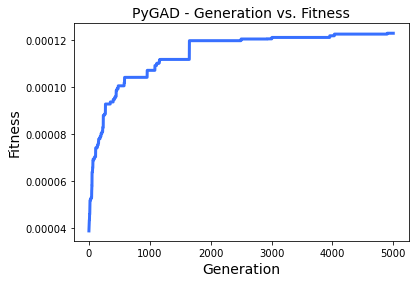

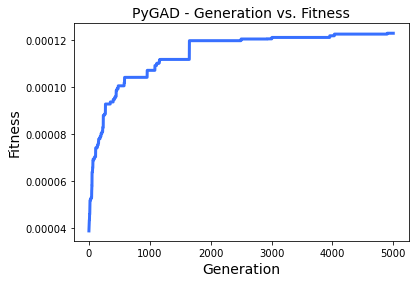

In [257]:
ga_instance.plot_fitness()

In [258]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(tier1.loc[x].Home, "\t\t\t" , tier1.loc[x].gs, "\t\t" , tier1.loc[x].rd)

Parameters of the best solution : [206 212 104 298  99 199 194  26 189 243  87 131  56  62 112  60 113  31
 490 278 528 423 147 405 439 334 518 225 508 573  88 540 136  49 375 350
 430 293 242   8 282 458]
Fitness value of the best solution = 407.0164552013408
Index of the best solution : 0



Bath Men's 3 			 1536.8313417425527 		 50.43299274815013
Bath Men's 2 			 2045.7300075545324 		 50.43230001169927
Birmingham Men's 3 			 2042.7487060651683 		 50.42776645162155
UWE Men's 1 			 1578.2836200772044 		 50.9541162680308
Birmingham Men's 4 			 1540.0331657081947 		 50.95190143315499
Oxford Men's 2 			 1980.687694373417 		 49.91515109268881



Durham Men's 4 			 1545.3068463428947 		 50.95461899846416
Newcastle Men's 1 			 2048.3390768136665 		 50.42792843404009
Durham Men's 3 			 2026.9247261288704 		 49.92438721006365
York Men's 1 			 1551.118123496716 		 50.42699087654226
Edinburgh Men's 3 			 2025.6010590292165 		 52.04444062210373
Heriot-Watt Men's 1 			 2002.5506976503625 		 50.43

In [226]:
allocated_ids = allocated_ids + [x for x in solution]

# tier 2

In [227]:
tier2 = mens_df.drop(allocated_ids)[:42]

In [228]:
tier2

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
148,Liverpool Men's 2,1535.463347,50.971753,Liverpool Men's 2,Men's,Liverpool,2,Liverpool,L18 6HF,53.380500,-2.908600
290,Exeter Men's 4,1533.236920,50.427743,Exeter Men's 4,Men's,Exeter,4,Exeter,EX4 4QN,50.737760,-3.529700
94,Birmingham Men's 5,1532.689127,50.951551,Birmingham Men's 5,Men's,Birmingham,5,Birmingham,B15 2GR,52.462300,-1.921200
466,LSE Men's 1,1527.762297,50.970231,LSE Men's 1,Men's,LSE,1,LSE,E20 3AD,51.546800,-0.009600
373,Strathclyde Men's 2,1526.825231,50.431344,Strathclyde Men's 2,Men's,Strathclyde,2,Strathclyde,G33 6ND,55.889000,-4.152100
268,Manchester Men's 2,1525.958406,51.522080,Manchester Men's 2,Men's,Manchester,2,Manchester,M14 6HE,53.448200,-2.225700
318,Sheffield Men's 1,1523.491939,50.429536,Sheffield Men's 1,Men's,Sheffield,1,Sheffield,S8 8PS,53.343900,-1.478150
48,Glasgow Men's 2,1523.115348,50.951685,Glasgow Men's 2,Men's,Glasgow,2,Glasgow,G20 0SP,55.890600,-4.290400
151,Liverpool John Moores Men's 1,1517.214111,50.451152,Liverpool John Moores Men's 1,Men's,Liverpool John Moores,1,Liverpool John Moores,L37 7DP,53.551500,-3.042633
30,Loughborough Men's 4,1515.703516,51.491826,Loughborough Men's 4,Men's,Loughborough,4,Loughborough,LE11 3TU,52.766700,-1.200000


[148, 290, 94, 466, 373, 268, 318, 48, 151, 30, 1, 426, 75, 396, 435, 347, 118, 250, 325, 339, 296, 502, 365, 21, 162, 549, 514, 257, 578, 459, 359, 475, 209, 264, 585, 11, 448, 535, 201, 454, 411, 150]


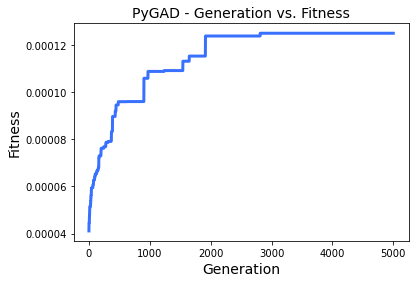

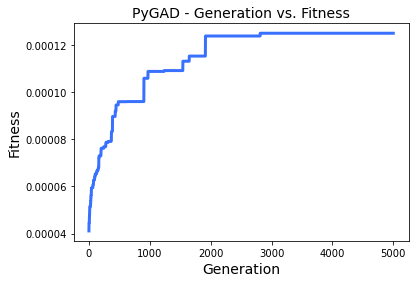

In [259]:
ds = tier2

function_inputs = [x for x in ds.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=ds, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in ds.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()
ga_instance.plot_fitness()

In [260]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(ds.loc[x].Home, "\t\t\t" , ds.loc[x].gs, "\t\t" , ds.loc[x].rd)

Parameters of the best solution : [549 435 339 162 347 459 250 201  30 396 475 318 118 257 411 264 296  94
 514 585  75 448 365 466 373 325  21 359 502  48 150 578 535 151 268 148
   1 454  11 209 426 290]
Fitness value of the best solution = 400.12548820117064
Index of the best solution : 0



St Mary's Men's 1 			 1480.5330789081495 		 50.96469042288372
Portsmouth Men's 2 			 1509.115539721431 		 49.91745591358232
Brunel Men's 1 			 1495.544394656138 		 49.93044692622029
Imperial Men's 2 (Medics) 			 1484.5478075027886 		 50.94649306768616
Royal Holloway Men's 1 			 1503.5254189384325 		 50.4252334424908
King's College Men's 2 			 1468.040926972605 		 49.92065801532625



Sheffield Hallam Men's 2 			 1500.446391180031 		 50.42697674050243
Aston Men's 1 			 1405.808597947655 		 50.42412978940077
Loughborough Men's 4 			 1515.7035162688053 		 51.49182552590904
Leeds Men's 2 			 1509.3521207062554 		 50.42699757867514
Leicester Men's 1 			 1462.828573902778 		 50.4306032199008
Sheffield

In [231]:
allocated_ids = allocated_ids + [x for x in solution]

# Tier 3

In [232]:
tier3 = mens_df.drop(allocated_ids)[:42]

In [233]:
tier3

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
153,Edinburgh Napier Men's 1,1285.374199,59.554962,Edinburgh Napier Men's 1,Men's,Edinburgh Napier,1,Edinburgh Napier,EH16 5LL,55.922500,-3.151133
55,Nottingham Men's 6,1279.400798,53.221212,Nottingham Men's 6,Men's,Nottingham,6,Nottingham,NG7 2PS,52.953600,-1.150500
288,Exeter Men's 6,1278.959931,51.496214,Exeter Men's 6,Men's,Exeter,6,Exeter,EX4 4QN,50.737760,-3.529700
385,Kent Men's 2,1264.970816,51.502238,Kent Men's 2,Men's,Kent,2,Kent,CT2 7SR,51.297750,1.091560
32,Loughborough Men's 5,1258.662186,50.440906,Loughborough Men's 5,Men's,Loughborough,5,Loughborough,LE11 3TU,52.766700,-1.200000
246,York Men's 2,1255.326020,51.483058,York Men's 2,Men's,York,2,York,YO10 5NA,53.957600,-1.082700
568,Queen Mary Men's 1 (Barts),1247.084208,62.394873,Queen Mary Men's 1 (Barts),Men's,Queen Mary (Barts),1,Queen Mary (Barts),E20 3AD,51.546800,-0.009600
493,Queen Mary Men's 2,1240.240646,62.394869,Queen Mary Men's 2,Men's,Queen Mary,2,Queen Mary,E20 3AD,51.546800,-0.009600
494,East Anglia Men's 1,1239.313737,50.976620,East Anglia Men's 1,Men's,East Anglia,1,East Anglia,NR4 7TJ,52.616460,1.243680
418,Cardiff Men's 4 (Medics),1233.799605,50.425270,Cardiff Men's 4 (Medics),Men's,Cardiff (Medics),4,Cardiff (Medics),CF14 3AT,51.519900,-3.204000


[153, 55, 288, 385, 32, 246, 568, 493, 494, 418, 496, 567, 537, 410, 86, 114, 303, 270, 227, 333, 236, 240, 504, 16, 175, 133, 306, 368, 89, 124, 485, 314, 483, 591, 179, 196, 191, 335, 219, 210, 69, 427]


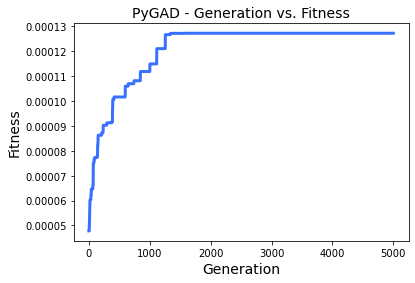

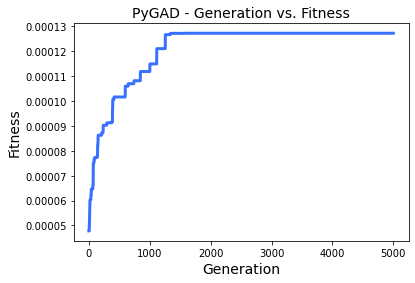

In [261]:
ds = tier3

function_inputs = [x for x in ds.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=ds, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in ds.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()
ga_instance.plot_fitness()

In [262]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(ds.loc[x].Home, "\t\t\t" , ds.loc[x].gs, "\t\t" , ds.loc[x].rd)

Parameters of the best solution : [568 567 496 494 175 385 236 288  16 418 240 427 485 191 133  86 153  89
 333  69 335 493 179 410 114  55 537 306  32 246 196 227 219 210 368 124
 504 270 483 314 591 303]
Fitness value of the best solution = 392.9133673110919
Index of the best solution : 0



Queen Mary Men's 1 (Barts) 			 1247.0842077502905 		 62.39487258041514
Queen Mary Men's 2 (Barts) 			 1231.932742499415 		 56.42410598183091
East Anglia Men's 2 			 1231.9446791754324 		 59.60729110636065
East Anglia Men's 1 			 1239.3137366911722 		 50.97661981459896
City Men's 1 			 1211.0993154291975 		 49.94065167711553
Kent Men's 2 			 1264.9708157762375 		 51.50223760166936



Bristol Men's 5 			 1218.793302159822 		 52.03933082227604
Exeter Men's 6 			 1278.959931305591 		 51.49621444079881
Cardiff Men's 5 			 1215.3430178023807 		 51.49732800461958
Cardiff Men's 4 (Medics) 			 1233.799604501556 		 50.42526968758123
Bristol Men's 4 			 1217.1400973633945 		 50.42510856197716
Swansea Men's 

In [236]:
allocated_ids = allocated_ids + [x for x in solution]


# tier 4

In [237]:
tier4 = mens_df.drop(allocated_ids)[:42]
tier4

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
481,Lincoln Men's 1,1164.938253,50.959261,Lincoln Men's 1,Men's,Lincoln,1,Lincoln,LN6 7TS,53.188415,-0.641369
519,Edge Hill Men's 1,1161.536348,49.928841,Edge Hill Men's 1,Men's,Edge Hill,1,Edge Hill,L39 4QP,53.555600,-2.909410
457,Bournemouth Men's 2,1156.436577,51.490070,Bournemouth Men's 2,Men's,Bournemouth,2,Bournemouth,BH23 6BL,50.755407,-1.757767
402,Leeds Men's 3,1153.377591,50.429611,Leeds Men's 3,Men's,Leeds,3,Leeds,LS16 5AU,53.868475,-1.598100
169,St George's Men's 1,1152.951945,50.448063,St George's Men's 1,Men's,St George's,1,St George's,KT7 0AE,51.389600,-0.339300
129,Heriot-Watt Men's 2,1146.201385,50.960636,Heriot-Watt Men's 2,Men's,Heriot-Watt,2,Heriot-Watt,EH16 5LL,55.922500,-3.151133
554,Solent Men's 1,1118.429479,51.495683,Solent Men's 1,Men's,Solent,1,Solent,SO16 7AY,50.942125,-1.431825
213,Derby Men's 1,1109.003675,53.817282,Derby Men's 1,Men's,Derby,1,Derby,DE22 1JD,52.953100,-1.521125
258,Warwick Men's 3,1106.552374,52.063612,Warwick Men's 3,Men's,Warwick,3,Warwick,CV4 8AH,52.383300,-1.583300
473,Aberystwyth Men's 1,1097.321651,51.490404,Aberystwyth Men's 1,Men's,Aberystwyth,1,Aberystwyth,SA48 7BX,52.154116,-4.111800


[481, 519, 457, 402, 169, 129, 554, 213, 258, 473, 377, 491, 156, 555, 552, 44, 286, 71, 146, 489, 245, 238, 460, 315, 327, 432, 111, 37, 317, 346, 93, 64, 261, 526, 123, 53, 515, 79, 128, 266, 163, 595]


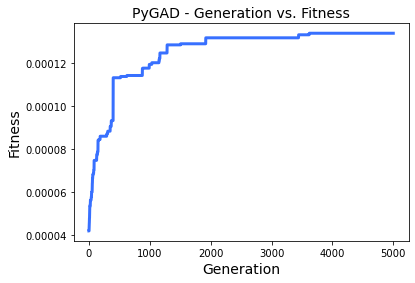

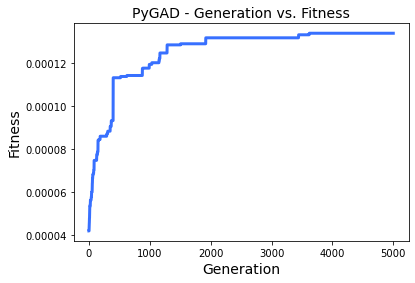

In [263]:
ds = tier4

function_inputs = [x for x in ds.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=ds, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in ds.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()
ga_instance.plot_fitness()

In [264]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(ds.loc[x].Home, "\t\t\t" , ds.loc[x].gs, "\t\t" , ds.loc[x].rd)

Parameters of the best solution : [ 37  53 111 317 481 213 473 286 552 432 238 327 346 554 515 457 169 128
 258 261 123 526 266  93 315 245 519 146 402 489 460 595 491  71  64 163
  44 555 156  79 129 377]
Fitness value of the best solution = 373.74897331573743
Index of the best solution : 0



Loughborough Men's 6 			 921.6399461522724 		 66.60033181400138
Nottingham Men's 7 			 912.1546227342384 		 66.601802310621
Nottingham Trent Men's 6 			 922.2406158214778 		 69.04519403989283
Sheffield Men's 4 			 920.8875694813872 		 54.47206444627909
Lincoln Men's 1 			 1164.938253186476 		 50.95926109389755
Derby Men's 1 			 1109.003674580269 		 53.81728167676749



Aberystwyth Men's 1 			 1097.3216511646983 		 51.49040385311006
Exeter Men's 7 			 947.4020911669372 		 67.75736128743836
Marjon Men's 1 			 988.5126491118848 		 58.83334304144955
Swansea Men's 4 			 923.9432826017472 		 57.28279755250357
Bristol Men's 6 			 930.0020840964906 		 54.52140564877334
USW Men's 1 			 926.7156497086984 

In [240]:
allocated_ids = allocated_ids + [x for x in solution]

# tier 5

In [241]:
tier5 = mens_df.drop(allocated_ids)[:42]
tier5

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
571,Bedfordshire Men's 1,900.122738,64.408735,Bedfordshire Men's 1,Men's,Bedfordshire,1,Bedfordshire,LU1 3JU,51.869300,-0.425280
506,Surrey Men's 2,898.528969,49.919982,Surrey Men's 2,Men's,Surrey,2,Surrey,GU2 7AD,51.243850,-0.597750
400,Leeds Men's 5,894.785511,55.814411,Leeds Men's 5,Men's,Leeds,5,Leeds,LS16 5AU,53.868475,-1.598100
379,Northampton Men's 1,893.077665,58.889573,Northampton Men's 1,Men's,Northampton,1,Northampton,NN3 7QL,52.275820,-0.833080
452,Plymouth Men's 2,892.862498,55.828430,Plymouth Men's 2,Men's,Plymouth,2,Plymouth,PL6 8BH,50.418983,-4.113467
127,Oxford Brookes Men's 5,892.688863,60.547215,Oxford Brookes Men's 5,Men's,Oxford Brookes,5,Oxford Brookes,OX3 0GB,51.780400,-1.217167
82,Edinburgh Men's 7,891.502532,69.023127,Edinburgh Men's 7,Men's,Edinburgh,7,Edinburgh,EH16 5LL,55.922500,-3.151133
356,Aberdeen Men's 2,889.382764,54.501207,Aberdeen Men's 2,Men's,Aberdeen,2,Aberdeen,AB24 5RU,57.143700,-2.098100
349,Dundee Men's 2,888.469370,54.493525,Dundee Men's 2,Men's,Dundee,2,Dundee,DD2 1UQ,56.477777,-3.058946
511,Canterbury CC Men's 2,887.235733,51.498112,Canterbury CC Men's 2,Men's,Canterbury CC,2,Canterbury CC,CT3 4AF,51.300053,1.173620


[571, 506, 400, 379, 452, 127, 82, 356, 349, 511, 413, 424, 332, 274, 524, 203, 253, 217, 166, 468, 583, 574, 305, 137, 398, 22, 340, 546, 450, 529, 541, 482, 393, 437, 478, 363, 415, 343, 216, 471, 390, 299]


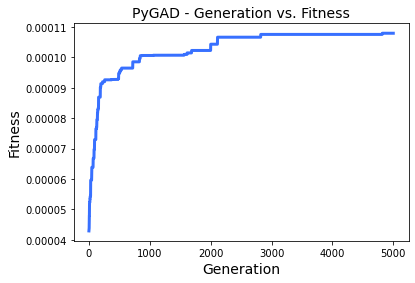

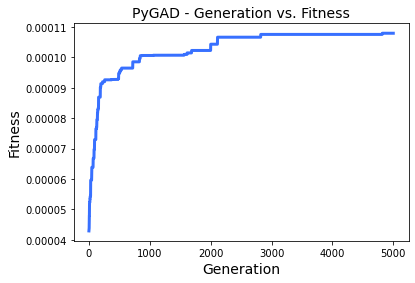

In [265]:
ds = tier5

function_inputs = [x for x in ds.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=ds, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in ds.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()
ga_instance.plot_fitness()

In [266]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(ds.loc[x].Home, "\t\t\t" , ds.loc[x].gs, "\t\t" , ds.loc[x].rd)


Parameters of the best solution : [305 390 379 424 299 413 166 468 506 574 332 340 437 524 216 217 471 452
 400  22  82 398 415 274 343 203 529 482 478 253 571 393 127 583 511 450
 137 546 356 363 541 349]
Fitness value of the best solution = 463.45916068797277
Index of the best solution : 0



Harper Adams Men's 2 			 870.5490221706506 		 66.6614761457411
Worcester Men's 1 			 803.6340186997136 		 59.67427942071911
Northampton Men's 1 			 893.0776645103127 		 58.88957257392661
Birmingham City Men's 2 			 883.915247147339 		 66.65882140745514
UWE Men's 3 			 794.405675351984 		 52.683073673765385
Gloucestershire Men's 2 			 884.3015811523047 		 64.42938523077892



Imperial Men's 4 (Medics) 			 875.21809044521 		 54.48973612531214
LSE Men's 2 			 874.6852296044844 		 53.22048160828378
Surrey Men's 2 			 898.5289688154712 		 49.91998182899587
Chichester Men's 2 			 873.0217557535948 		 62.393924803874
Imperial Men's 6 			 883.1917762172105 		 56.42999162655583
Brunel Men's 2 			 863.176

In [244]:
allocated_ids = allocated_ids + [x for x in solution]

# tier 6

In [245]:
tier6 = mens_df.drop(allocated_ids)[:42]
tier6

,names,gs,rd,Home,Team Type,Home Institute,Home Team,Modified Home,Venue Postcode,Lat,Lon
336,Imperial Men's 5,774.287060,55.836994,Imperial Men's 5,Men's,Imperial,5,Imperial,TW7 4NQ,51.475200,-0.342500
230,Reading Men's 4,735.701398,62.338508,Reading Men's 4,Men's,Reading,4,Reading,RG6 6UR,51.439600,-0.929200
561,Bradford Men's 1,735.460717,55.828311,Bradford Men's 1,Men's,Bradford,1,Bradford,BD9 4JP,53.812800,-1.791900
441,Royal Veterinary College Men's 1,734.409831,58.051850,Royal Veterinary College Men's 1,Men's,Royal Veterinary College,1,Royal Veterinary College,EN6 3BW,51.697980,-0.183100
28,Newcastle Men's 4,731.501791,57.261708,Newcastle Men's 4,Men's,Newcastle,4,Newcastle,NE12 8AD,55.029000,-1.567600
249,York Men's 4,728.081051,61.376155,York Men's 4,Men's,York,4,York,YO10 5NA,53.957600,-1.082700
548,UCLan Men's 1,713.250509,55.808473,UCLan Men's 1,Men's,UCLan,1,UCLan,PR2 1SG,53.782980,-2.692140
569,Queen Mary Men's 3 (Barts),708.027288,65.503119,Queen Mary Men's 3 (Barts),Men's,Queen Mary (Barts),3,Queen Mary (Barts),E20 3AD,51.546800,-0.009600
499,Northumbria Men's 2,707.167639,59.618230,Northumbria Men's 2,Men's,Northumbria,2,Northumbria,NE29 6TL,55.016500,-1.449300
337,Imperial Men's 7,704.599997,64.419896,Imperial Men's 7,Men's,Imperial,7,Imperial,TW7 4NQ,51.475200,-0.342500


[336, 230, 561, 441, 28, 249, 548, 569, 499, 337, 165, 386, 279, 560, 588, 276, 161, 539, 180, 388, 74, 407, 433, 580, 445, 172, 171, 309]


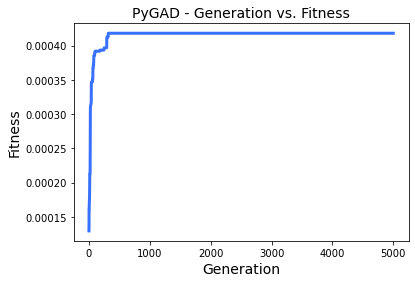

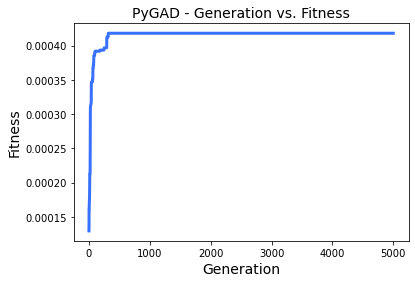

In [267]:
ds = tier6

function_inputs = [x for x in ds.index]
print(function_inputs)
num_generations = 5000
num_parents_mating = 4

fitness_function = fitness_func_fact(d_tab=ds, n_teams_per_league=6, n_leagues=7)

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10    
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=[x for x in ds.index],
                       gene_type=int,
#                        init_range_low=init_range_low,
#                        init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       allow_duplicate_genes=False,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       parallel_processing=5)

ga_instance.run()
ga_instance.plot_fitness()

In [268]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=(1.0/solution_fitness)/20))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

for i, x in enumerate(solution):
    if i % 6 == 0:
        print("\n\n")
    print(ds.loc[x].Home, "\t\t\t" , ds.loc[x].gs, "\t\t" , ds.loc[x].rd)


Parameters of the best solution : [386 388 180 588 337 161 336 165 548 276 171 433 441 569 445  74 230 580
 172 279 407 309 561 560 499  28 539 249]
Fitness value of the best solution = 119.64081845129917
Index of the best solution : 0



Kent Men's 3 			 697.0747718418729 		 56.546361609934806
Greenwich Men's 1 			 653.9909265729902 		 58.85015327627541
King's College Men's 5 (GKT) 			 664.6175175649552 		 56.55563344973648
East London Men's 1 			 674.8647103452108 		 65.51120804656884
Imperial Men's 7 			 704.5999974395374 		 64.41989575910405
Imperial Men's 7 (Medics) 			 665.1419043149197 		 60.47517646824571



Imperial Men's 5 			 774.2870598915514 		 55.83699439630156
Imperial Men's 6 (Medics) 			 700.8908461794042 		 65.52109107914954
UCLan Men's 1 			 713.2505092861601 		 55.808472871463096
Manchester Men's 5 			 674.6297751813252 		 56.54077483420723
Bolton Men's 1 			 623.67729007041 		 52.65772874621569
Huddersfield Men's 1 			 641.9839265305258 		 55.830793416137006



Roy